ECML-PKDD 2020 Hands-on Tutorial

*What and How of Machine Learning Transparency*:  
Building Bespoke Explainability Tools with Interoperable Algorithmic Components

<https://events.fat-forensics.org/2020_ecml-pkdd/>

Authors: Kacper Sokol <k.sokol@bristol.ac.uk> and
         Alex Hepburn <ah13558@bristol.ac.uk>  
Licence:
[![Text Licence](https://img.shields.io/badge/licence--text-CC%20BY--NC--SA%204.0-red)](https://github.com/fat-forensics/Surrogates-Tutorial/blob/master/LICENCE)
[![Code Licence](https://img.shields.io/badge/licence--code-new%20BSD-red)](https://github.com/fat-forensics/Surrogates-Tutorial/blob/master/LICENCE-code)

---

---

---

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fat-forensics/Surrogates-Tutorial/blob/master/notebooks/1-data-sets.ipynb)
[![Open in Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/fat-forensics/Surrogates-Tutorial/master?filepath=notebooks%2F1-data-sets.ipynb)

First, we need to set up the environment.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
LIBRARY_URL = ('https://raw.githubusercontent.com/fat-forensics/'
               'Surrogates-Tutorial/master/notebooks/fatf_ecml.py')

try:
    import google.colab
    !wget $LIBRARY_URL -O fatf_ecml.py
except ImportError:
    pass

import fatf_ecml

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display

%matplotlib inline

In [3]:
fatf_ecml.initialise_colab()

Not in Colab; nothing to do.


In [4]:
import sklearn.metrics

# Introducing Data Sets and Black Boxes #
This notebook briefly introduces example data sets that we will use
throughout the tutorial:

- *Two Moons* -- a two-dimensional toy data set; and
- *Bikes Sharing* -- a real-life data set that captures bike rentals
  (available via the
  [UCI repository](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset)
  ).

Moreover, it discusses two classifiers that will serve as our *black boxes*
(trained on said data):

- Random Forest -- utilises the `sklearn.ensemble.RandomForestClassifier` class
  and serves as a probabilistic black box; and
- Support Vector Machine -- uses the `sklearn.svm.SVC` class and serves as
  a non-probabilistic black box.

---

**Reproducibility**&nbsp;&nbsp;&nbsp;&nbsp;
To ensure reproducibility of the data -- random generation of Two Moons
and train/test split of both data sets -- we encourage fixing the random
seeds of the Python's and numpy's `random` modules.
This can be easily done by calling `fatf.setup_random_seed(42)`, where `42`
is the chosen random seed.
This step is already integrated into the data set creation functions
-- `fatf_ecml.generate_2d_moons` and `fatf_ecml.generate_bikes` -- and can
be accessed with their `random_seed` parameter, e.g.:
```
>>> fatf_ecml.generate_2d_moons(random_seed=42)
```
If called without this parameter or with `None`, the random seed is not fixed.

Similarly, you may wish to train reproducible models.
This can be achieved by using the `random_state` parameter, which every
scikit-learn model class has, e.g., `sklearn.svm.SVC(random_state=42)`.
Again, this functionality has already been integrated into the model creation
functions in the `fatf_ecml` library -- `fatf_ecml.get_random_forest` and
`fatf_ecml.get_svc` -- and can be accessed via their `random_seed` parameter,
e.g.:
```
>>> fatf_ecml.get_svc(data, target, random_seed=42)
```
If called without this parameter or with `None`, the random seed is not fixed.

---

**Storing Variables**&nbsp;&nbsp;&nbsp;&nbsp;
It is possible to *store* a variable in one Jupyter Notebook and *load* it
in another.
You can do so with two *magic* commands:
```
%store variable_name
```
to store a variable named `variable_name` and
```
%store -r variable_name
```
to load a variable named `variable_name`.
You can also list all of the stored variables by using the `%store` magic
function without any parameter, i.e.:
```
%store
```
More information can be found
[here](https://ipython.readthedocs.io/en/stable/config/extensions/storemagic.html).
**Unfortunately, this feature does not work with Colab.**

---

> **Note**&nbsp;&nbsp;&nbsp;&nbsp; If you want to see the source code of
  any function, you can use another *magic* command available in
  Jupyter Notebooks:
  ```
  ?? fatf_ecml.initialise_colab
  ```
  Execute the cell below to see how it works.

In [5]:
#PYTEST_VALIDATE_IGNORE_OUTPUT
?? fatf_ecml.initialise_colab

Signature:  fatf_ecml.initialise_colab()
Source:   
def initialise_colab():
    """
    Installs FAT Forensics with all its auxiliary dependencies when in Colab.
    """
    global FATF_INSTALLED
    if IN_COLAB:
        if not FATF_INSTALLED:
            print('Installing FAT Forensics.')
            stream = os.popen(
                '{} -m pip install fat-forensics[all]'.format(sys.executable))
            output = stream.read()
            print(output)
            FATF_INSTALLED = True
        else:
            print('FAT Forensics is already installed.')
    else:
        print('Not in Colab; nothing to do.')
File:      ~/Surrogates-Tutorial/notebooks/fatf_ecml.py
Type:      function


## Two Moons ##
First, let's generate a *toy* data set that is two-dimensional and easy to
visualise.
It will help us to introduce plenty of concepts throughout this tutorial.

To this end, we use scikit-learn's `sklearn.datasets.make_moons` function.
We generate a two moons data set with 1500 samples and 0.25 noise.
Next, we scale both of its features to the [0, 1] range.
Then, we separate 20% of the data into a *test* set.

For convenience, this procedure is neatly wrapped inside the
`generate_2d_moons` function in our dedicated ECML-PKDD 2020 tutorial
library `fatf_ecml`.
(We have already downloaded and imported it at the very top of this notebook.)

Let's generate this data set.

In [6]:
# Generate 2-D moons data set
moons_train_X, moons_test_X, moons_train_y, moons_test_y = (
    fatf_ecml.generate_2d_moons(random_seed=42)
)

22-Sep-08 12:52:52 fatf         INFO     Seeding RNGs using the input parameter.
22-Sep-08 12:52:52 fatf         INFO     Seeding RNGs with 42.


Let's plot the *training* data first...

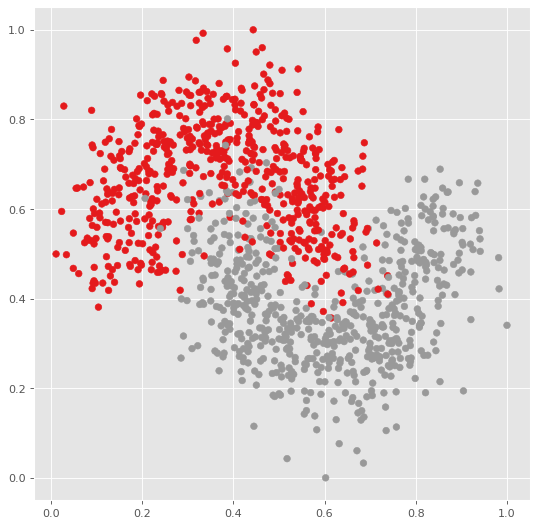

In [7]:
# Plot training data and their labels
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(moons_train_X[:, 0], moons_train_X[:, 1],
            cmap=plt.cm.Set1, c=moons_train_y)

...followed by the *test* data.

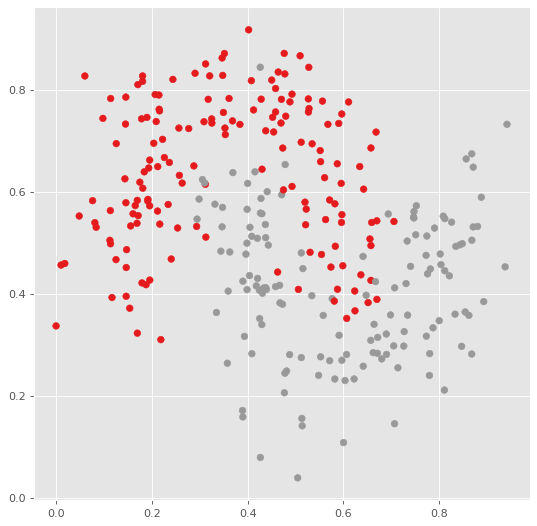

In [8]:
# Plot test data and their labels
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(moons_test_X[:, 0], moons_test_X[:, 1],
            cmap=plt.cm.Set1, c=moons_test_y)

## Bikes ##
Our second data set is *Bike Sharing*, which is distributed via the
[UCI repository](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset).
It records a number of bike rentals (target) along various weather conditions
and date artefacts (features).
The version used in this tutorial has the following 11 features:

- season:
  1. winter,
  2. spring,
  3. summer, and
  4. fall;
- year:
  0. 2011, and
  1. 2012;
- month -- 1 to 12;
- holiday -- weather the day is a holiday or not;
- weekday -- the day of the week;
- workingday -- 1 if the day is neither during the weekend nor a holiday,
  otherwise 0;
- weathersit:
  1. clear, few clouds, partly cloudy, partly cloudy,
  2. mist + cloudy, mist + broken clouds, mist + few clouds, mist,
  3. light snow, light rain + thunderstorm + scattered clouds,
     light rain + scattered clouds, and
  4. heavy rain + ice pallets + thunderstorm + mist, snow + fog;
- temp -- normalized temperature in Celsius;
- atemp -- normalized feeling temperature in Celsius;
- hum -- normalized humidity; and
- windspeed -- normalized wind speed.

In its original form, the target of the data set is the number of bikes used
on a given day, making it a regression task.
However, for the purposes of this tutorial, we convert it into a
classification problem.
We create a target variable that describes the day as having
**low**, **medium** or **high** bike usage, which are defined by the
following thresholds:

- **low:** $0 \leq y < 4000$,
- **medium:** $4000 \leq y < 6000$, and
- **high:** $6000 \leq y < 9000$;

where $y$ is the number of bikes rented on a given day.

---

All of this processing is done in the `generate_bikes` function, which
is available in the `fatf_ecml` library.
Let's use it to load the data.

In [9]:
(bikes_train_X,
 bikes_test_X,
 bikes_train_y,
 bikes_test_y,
 bikes_feature_names,
 bikes_target_name) = fatf_ecml.generate_bikes(random_seed=42)

bikes_target_classes = ['low', 'medium', 'high']

22-Sep-08 12:52:55 fatf         INFO     Seeding RNGs using the input parameter.
22-Sep-08 12:52:55 fatf         INFO     Seeding RNGs with 42.


In [10]:
print('Features number: {}.'.format(bikes_train_X.shape[1]))
print('Training instances number: {}.'.format(bikes_train_X.shape[0]))
print('Testing instances number: {}.'.format(bikes_test_X.shape[0]))

Features number: 11.
Training instances number: 584.
Testing instances number: 147.


Now, let's visualise the class proportions for the training and test sets.


Text(0.5, 1.0, 'Class Distribution of Test Data')

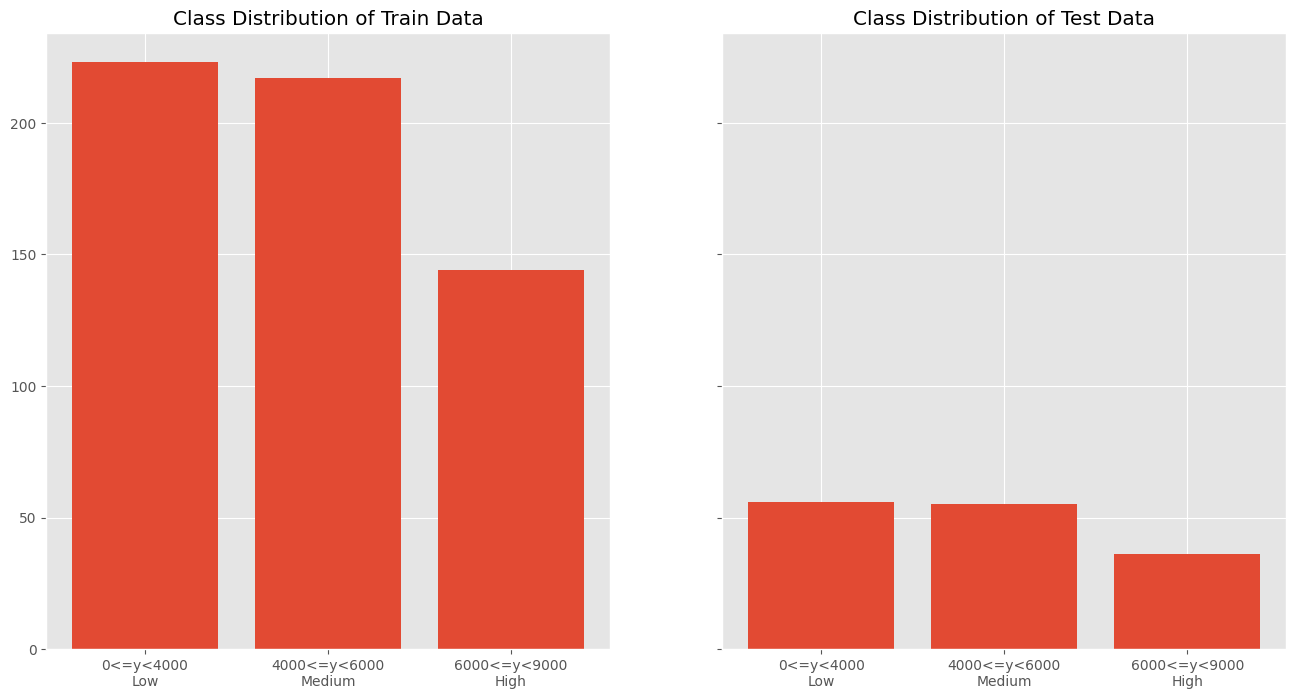

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)

bins = [0, 4000, 6000, 9000]
bin_names = [
    '{:.0f}<=y<{:.0f}\nLow'.format(bins[0], bins[1]),
    '{:.0f}<=y<{:.0f}\nMedium'.format(bins[1], bins[2]),
    '{:.0f}<=y<{:.0f}\nHigh'.format(bins[2], bins[3])
]

_, train_counts = np.unique(bikes_train_y, return_counts=True)
axs[0].bar(bin_names, train_counts)
axs[0].set_title('Class Distribution of Train Data')

_, test_counts = np.unique(bikes_test_y, return_counts=True)
axs[1].bar(bin_names, test_counts)
axs[1].set_title('Class Distribution of Test Data')

## Training Models ##
Now, let's train *black box* models on these data sets and evaluate their
train and test set predictive performance.
We will use two models:

* `sklearn.ensemble.RandomForestClassifier` treated as a *probabilistic*
  classifier; and
* `sklearn.svm.SVC` operated as a *crisp* (non-probabilistic) classifier.

### Two Moons ###

#### Random Forest ####
Let's start with a simple *probabilistic* model based on the Random Forest
classifier.

In [12]:
clf_moons_probabilistic = fatf_ecml.get_random_forest(
    moons_train_X, moons_train_y, random_seed=42)

22-Sep-08 12:52:59 fatf         INFO     Seeding RNGs using the input parameter.
22-Sep-08 12:52:59 fatf         INFO     Seeding RNGs with 42.


It has the following training set log loss:

In [13]:
moons_prob_predictions_train = clf_moons_probabilistic.predict_proba(
    moons_train_X)

moons_prob_train_performance = sklearn.metrics.log_loss(
    moons_train_y, moons_prob_predictions_train)

print('Training set *log loss*: {:.3}.'.format(moons_prob_train_performance))

Training set *log loss*: 0.116.


It has the following testing set log loss:

In [14]:
moons_prob_predictions_test = clf_moons_probabilistic.predict_proba(
    moons_test_X)

moons_prob_test_performance = sklearn.metrics.log_loss(
    moons_test_y, moons_prob_predictions_test)

print('Testing set *log loss*: {:.3}.'.format(moons_prob_test_performance))

Testing set *log loss*: 0.225.


#### Support Vector Machine ####
Next, we train a simple crisp (non-probabilistic) model.

In [15]:
clf_moons_crisp = fatf_ecml.get_svc(
    moons_train_X, moons_train_y, random_seed=42)

22-Sep-08 12:53:02 fatf         INFO     Seeding RNGs using the input parameter.
22-Sep-08 12:53:02 fatf         INFO     Seeding RNGs with 42.


It has the following training set accuracy:

In [16]:
moons_crisp_predictions_train = clf_moons_crisp.predict(
    moons_train_X)

moons_crisp_train_performance = sklearn.metrics.accuracy_score(
    moons_train_y, moons_crisp_predictions_train)

print('Training set *accuracy*: {:.3}.'.format(moons_crisp_train_performance))

Training set *accuracy*: 0.939.


It has the following testing set accuracy:

In [17]:
moons_crisp_predictions_test = clf_moons_crisp.predict(
    moons_test_X)

moons_crisp_test_performance = sklearn.metrics.accuracy_score(
    moons_test_y, moons_crisp_predictions_test)

print('Testing set *accuracy*: {:.3}.'.format(moons_crisp_test_performance))

Testing set *accuracy*: 0.91.


### Bikes ###

#### Random Forest ####
Let's start with a simple *probabilistic* model based on the Random Forest
classifier.

In [18]:
clf_bikes_probabilistic = fatf_ecml.get_random_forest(
    bikes_train_X, bikes_train_y, random_seed=42)

22-Sep-08 12:53:04 fatf         INFO     Seeding RNGs using the input parameter.
22-Sep-08 12:53:04 fatf         INFO     Seeding RNGs with 42.


It has the following training set log loss:

In [19]:
bikes_prob_predictions_train = clf_bikes_probabilistic.predict_proba(
    bikes_train_X)

bikes_prob_train_performance = sklearn.metrics.log_loss(
    bikes_train_y, bikes_prob_predictions_train)

print('Training set *log loss*: {:.3}.'.format(bikes_prob_train_performance))

Training set *log loss*: 0.267.


It has the following testing set log loss:

In [20]:
bikes_prob_predictions_test = clf_bikes_probabilistic.predict_proba(
    bikes_test_X)

bikes_prob_test_performance = sklearn.metrics.log_loss(
    bikes_test_y, bikes_prob_predictions_test)

print('Testing set *log loss*: {:.3}.'.format(bikes_prob_test_performance))

Testing set *log loss*: 0.411.


#### Support Vector Machine ####
Next, we train a simple crisp (non-probabilistic) model.

In [21]:
clf_bikes_crisp = fatf_ecml.get_svc(
    bikes_train_X, bikes_train_y, random_seed=42)

22-Sep-08 12:53:07 fatf         INFO     Seeding RNGs using the input parameter.
22-Sep-08 12:53:07 fatf         INFO     Seeding RNGs with 42.


It has the following training set accuracy:

In [22]:
bikes_crisp_predictions_train = clf_bikes_crisp.predict(
    bikes_train_X)

moons_crisp_train_performance = sklearn.metrics.accuracy_score(
    bikes_train_y, bikes_crisp_predictions_train)

print('Training set *accuracy*: {:.3}.'.format(moons_crisp_train_performance))

Training set *accuracy*: 0.771.


It has the following testing set accuracy:

In [23]:
bikes_crisp_predictions_test = clf_bikes_crisp.predict(
    bikes_test_X)

moons_crisp_test_performance = sklearn.metrics.accuracy_score(
    bikes_test_y, bikes_crisp_predictions_test)

print('Training set *accuracy*: {:.3}.'.format(moons_crisp_test_performance))

Training set *accuracy*: 0.776.


## Jupyter Variable Storage ##
(**This functionality is not available in Colab.**)

If you wish to reuse any of these variables in other notebooks,
you can store and load them with Jupyter *magic*: `%store` and `%store -r`
respectively, e.g.:

In [24]:
moons_data_dictionary = {
    'train': {
        'X': moons_train_X,
        'y': moons_train_y 
    },
    'test': {
        'X': moons_test_X,
        'y': moons_test_y 
    },
    'feature_names': ['feature_1', 'feature_2'],
    'class_names': ['class_1', 'class_2']
}

bikes_data_dictionary = {
    'train': {
        'X': bikes_train_X,
        'y': bikes_train_y 
    },
    'test': {
        'X': bikes_test_X,
        'y': bikes_test_y 
    },
    'feature_names': bikes_feature_names,
    'class_names':  bikes_target_classes
}

In [25]:
%store moons_data_dictionary
%store clf_moons_probabilistic
%store clf_moons_crisp

Stored 'moons_data_dictionary' (dict)
Stored 'clf_moons_probabilistic' (RandomForestClassifier)
Stored 'clf_moons_crisp' (SVC)


In [26]:
%store bikes_data_dictionary
%store clf_bikes_probabilistic
%store clf_bikes_crisp

Stored 'bikes_data_dictionary' (dict)
Stored 'clf_bikes_probabilistic' (RandomForestClassifier)
Stored 'clf_bikes_crisp' (SVC)


Let's see what variables are stored.

In [27]:
%store

Stored variables and their in-db values:
bikes_data_dictionary               -> {'train': {'X': array([[ 2.       ,  0.       ,  4
clf_bikes_crisp                     -> SVC(random_state=42)
clf_bikes_probabilistic             -> RandomForestClassifier(max_depth=7, n_estimators=5
clf_moons_crisp                     -> SVC(random_state=42)
clf_moons_probabilistic             -> RandomForestClassifier(max_depth=7, n_estimators=5
moons_data_dictionary               -> {'train': {'X': array([[0.5708247 , 0.31394848],
 


Now, let's overwrite one of them and restore it with `%store -r`.

In [28]:
moons_data_dictionary = None
print(moons_data_dictionary)

None


In [29]:
%store -r moons_data_dictionary

In [30]:
moons_data_dictionary.keys()

dict_keys(['train', 'test', 'feature_names', 'class_names'])